## Import Library

In [1]:
# Import library 
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam
import seaborn as sns

In [2]:
def resize_image(img_path, size):
    try:
        img = cv.imread(img_path)
        if img is None:
            raise ValueError(f"Image at {img_path} could not be read.")
        resized_img = cv.resize(img, size)
        return resized_img
    except Exception as e:
        print(f"Error resizing image {img_path}: {e}")
        return None

Loading dataset...
Dataset loaded with 200 images across 2 classes.


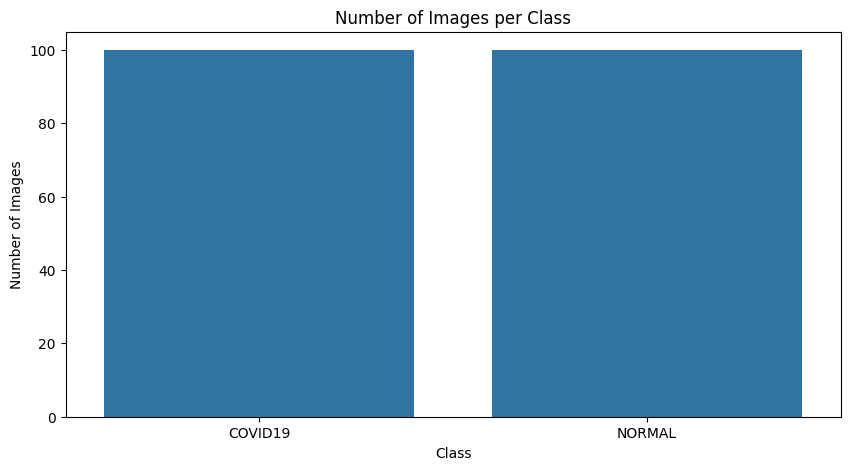

In [3]:
def load_dataset(dir):
    size = (250,250)
    images = []
    labels = []
    class_names = os.listdir(dir)
    class_counter = {class_name: 0 for class_name in class_names}

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(dir, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if class_counter[class_name] >= 100:
                    break
                img_path = os.path.join(class_dir, file_name)
                img = resize_image(img_path, size)
                if img is not None:
                    images.append(img)
                    labels.append(class_name)
                    class_counter[class_name]+=1
    return np.array(images), np.array(labels), class_names, class_counter


print("Loading dataset...")
images, labels, class_names, class_counter = load_dataset('Chest X_Ray Dataset')
print(f"Dataset loaded with {len(images)} images across {len(class_names)} classes.")
# Diagram Dataset
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counter.keys()), y=list(class_counter.values()))
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.savefig('dataset_distribution.png')
plt.show()

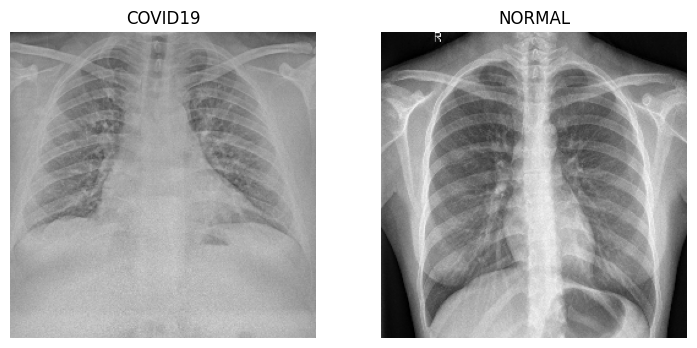

In [4]:
# Menampilkan gambar sample dari setiap kelas
def show_sample_images(images, labels, class_names):
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(class_names):
        class_images = images[labels == class_name]
        if len(class_images) > 0:
            plt.subplot(3, 4, i + 1)
            plt.imshow(cv.cvtColor(class_images[10], cv.COLOR_BGR2RGB))
            plt.title(class_name)
            plt.axis('off')
    plt.tight_layout()
    plt.show()
show_sample_images(images, labels, class_names)

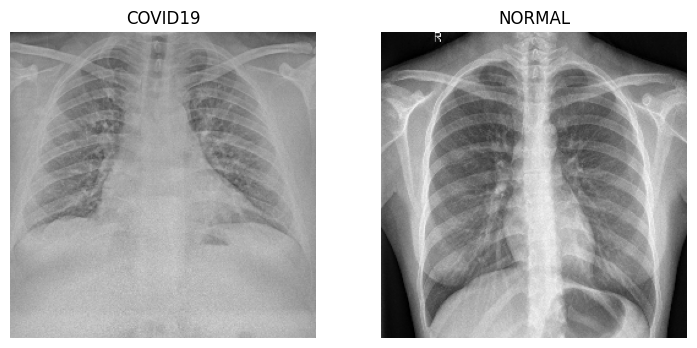

In [5]:
img_grey = []
for img in images:
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_grey.append(gray)
img_grey = np.array(img_grey)

show_sample_images(img_grey, labels, class_names)

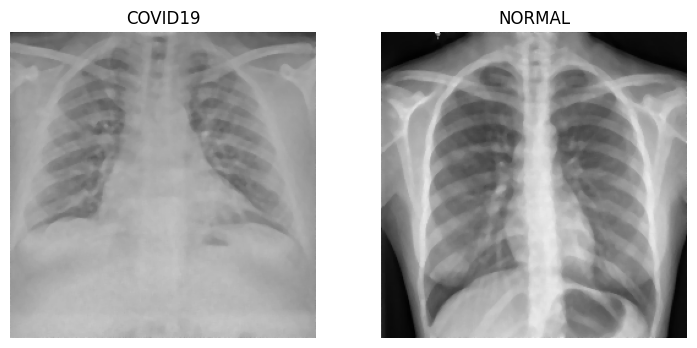

In [6]:
Px = np.array([[-1,0,1],
               [-1,0,1],
               [-1,0,1]])

Py = np.array([[1,1,1],
               [0,0,0],
               [-1,-1,-1]])

kernel_3x3 = np.full((3, 3), 1/9)

def median(img, kernel):
    height, width = img.shape
    hasil = img.copy().astype('int32')  
    
    for i in range(kernel.shape[0]//2, height - kernel.shape[0]//2):
        for j in range(kernel.shape[1]//2, width - kernel.shape[1]//2):
            temp = []
            for k in range(-kernel.shape[0]//2, kernel.shape[0]//2 + 1):
                for l in range(-kernel.shape[1]//2, kernel.shape[1]//2 + 1):
                    temp.append(int(img[i+k, j+l])) 
                    
            temp.sort() 
            mid = len(temp) // 2
            median_val = (temp[mid - 1] + temp[mid]) // 2
            hasil[i,j] = median_val
    
    return hasil.astype(img.dtype)

# Menerapkan konvolusi median
img_median = []
for img in img_grey:
    median_img = median(img, kernel_3x3)
    img_median.append(median_img)
img_median = np.array(img_median)
show_sample_images(img_median, labels, class_names)


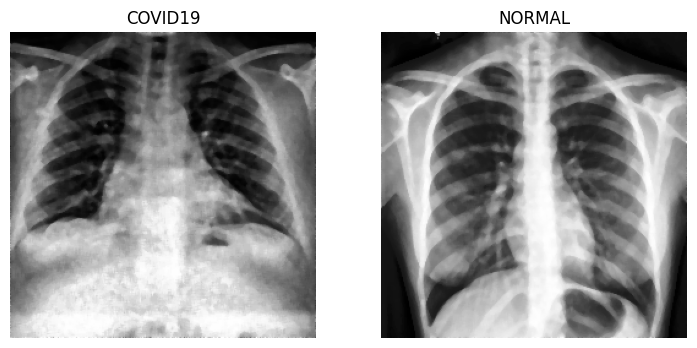

In [7]:
def equalization(image):
    hist = np.zeros(256).astype(int)
    height, width = image.shape
    for i in range(height):
        for j in range(width):
            val = image[i, j]
            hist[val] += 1

    gldc = np.zeros(256).astype(int)
    for i in range(256):
        gldc[i] = np.sum(hist[0:i+1])

    target_value = gldc * (256-1) / (height*width)
    target_value = np.floor(target_value).astype(np.uint8)  # konversi ke uint8 di sini

    result = np.zeros(image.shape, dtype=np.uint8)
    for i in range(height):
        for j in range(width):
            result[i, j] = target_value[image[i, j]]

    return result

# Proses ke semua gambar
img_equalization = []
for img in img_median:  
    equalization_img = equalization(img)
    img_equalization.append(equalization_img)
img_equalization = np.array(img_equalization)

# Tampilkan sample gambar
show_sample_images(img_equalization, labels, class_names)

In [8]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [9]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [10]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [11]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [12]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [13]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [14]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [15]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [16]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(img_median)):
    D0 = glcm(img_median[i], 0)
    D45 = glcm(img_median[i], 45)
    D90 = glcm(img_median[i], 90)
    D135 = glcm(img_median[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [17]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [18]:
for i in range(len(img_median)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [19]:
for i in range(len(img_median)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [20]:
for i in range(len(img_median)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [21]:
for i in range(len(img_median)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [22]:
for i in range(len(img_median)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [23]:
for i in range(len(img_median)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [24]:
for i in range(len(img_median)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [25]:
dataTable = {'Filename': [f'Image_{i+1}' for i in range(len(img_median))],
        'Class': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_pros3.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_pros3.csv')
hasilEkstrak = hasilEkstrak.drop(columns=['Filename'])
x = hasilEkstrak.drop(columns=['Class'])
y = hasilEkstrak['Class']


Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 20040.0625 - mae: 129.4070
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 20188.3047 - mae: 130.1185
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 20442.4844 - mae: 131.1101
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 19984.9707 - mae: 129.5921
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 20521.5645 - mae: 131.5556
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step


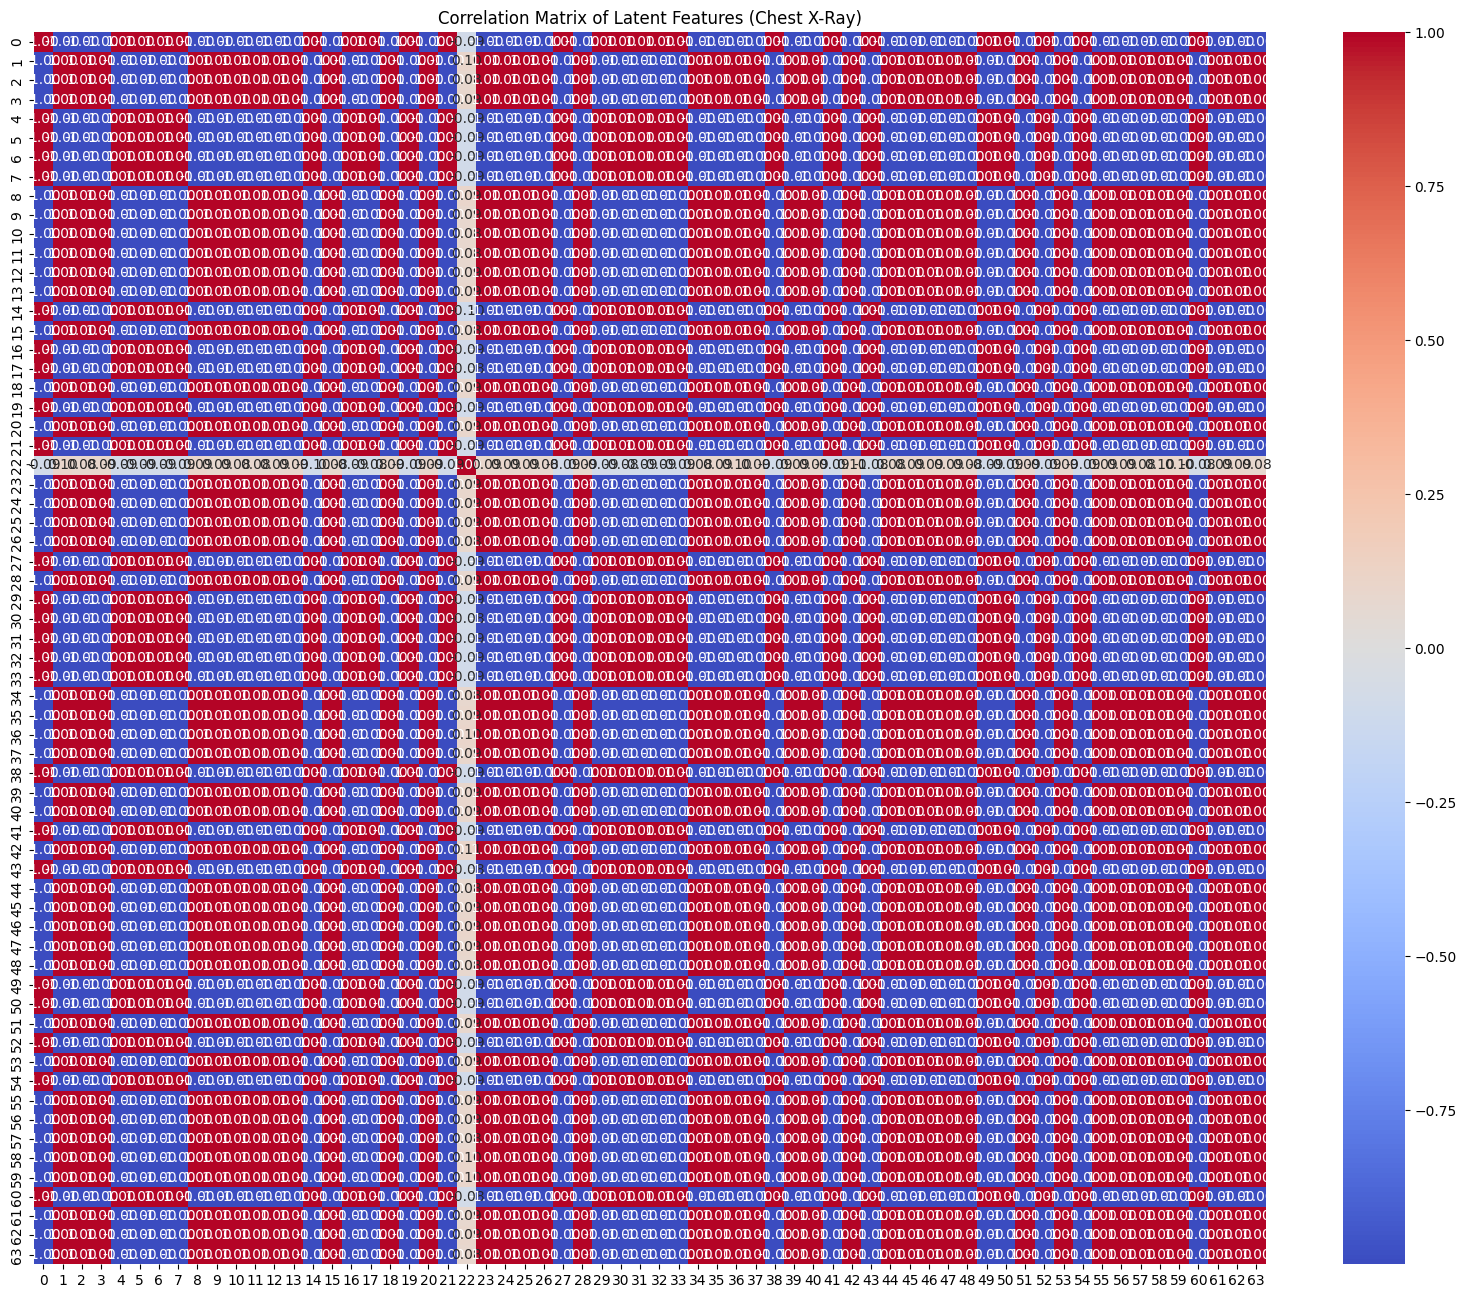

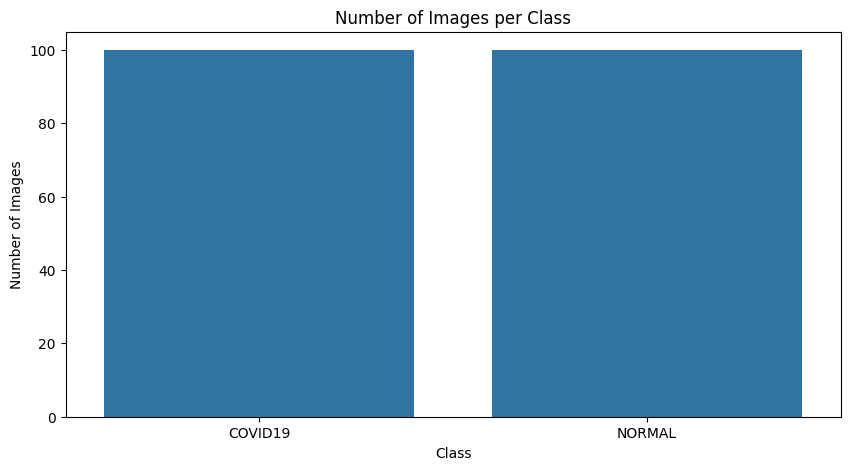

In [35]:
# Bangun autoencoder dengan input shape sesuai dataset grayscale
def build_convolutional_autoencoder(input_shape=(250, 250, 1), latent_dim=64):
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)  # 125x125x32
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # 63x63x64
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # 32x32x128

    shape_before_flattening = x.shape[1:]
    x = Flatten()(x)
    latent = Dense(latent_dim, name='latent_vector')(x)

    x = Dense(np.prod(shape_before_flattening))(latent)
    x = Reshape(target_shape=shape_before_flattening)(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # 64x64x128
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # 128x128x64
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)  # 256x256x32 (sedikit lebih besar dari 250)

    # Crop to (250, 250, 32)
    from tensorflow.keras.layers import Cropping2D
    x = Cropping2D(cropping=((3, 3), (3, 3)))(x)  # Crop 3 pixels from top/bottom and left/right

    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(inputs=input_img, outputs=decoded, name='autoencoder')
    encoder = Model(inputs=input_img, outputs=latent, name='encoder')

    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return autoencoder, encoder

autoencoder, encoder = build_convolutional_autoencoder(input_shape=(250, 250, 1), latent_dim=64)

# Latih model (5 epoch untuk contoh cepat)
autoencoder.fit(img_grey, img_grey, epochs=5, batch_size=32)

# Dapatkan latent features
latent_features = encoder.predict(img_grey)

# Hitung korelasi latent features
import pandas as pd
df_latent = pd.DataFrame(latent_features)
corr_matrix = df_latent.corr()

# Visualisasi heatmap korelasi
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Latent Features (Chest X-Ray)')
plt.show()

# Visualisasi distribusi dataset
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counter.keys()), y=list(class_counter.values()))
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

In [27]:
# 0.3 = 30% data untuk testing (train/test 70/30)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
print(f"Training set size: {len(x_train)}, Test set size: {len(x_test)}")
print(f"Training set size: {len(y_train)}, Test set size: {len(y_test)}")


Training set size: 140, Test set size: 60
Training set size: 140, Test set size: 60


In [28]:
def min_max_scaling(data):
    min_val = data.min(axis=0)
    max_val = data.max(axis=0)
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data

X_train_normalized = min_max_scaling(x_train)
X_test_normalized = min_max_scaling(x_test)

In [29]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

In [30]:
# Train Random Forest Classifier
rf.fit(x_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(x_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(x_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

     COVID19       0.99      0.99      0.99        69
      NORMAL       0.99      0.99      0.99        71

    accuracy                           0.99       140
   macro avg       0.99      0.99      0.99       140
weighted avg       0.99      0.99      0.99       140

[[68  1]
 [ 1 70]]
Accuracy: 0.9857142857142858

------Testing Set------
              precision    recall  f1-score   support

     COVID19       0.97      0.94      0.95        31
      NORMAL       0.93      0.97      0.95        29

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60

[[29  2]
 [ 1 28]]
Accuracy: 0.95


In [31]:
# Train SVM Classifier
svm.fit(x_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(x_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(x_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

     COVID19       0.94      0.72      0.82        69
      NORMAL       0.78      0.96      0.86        71

    accuracy                           0.84       140
   macro avg       0.86      0.84      0.84       140
weighted avg       0.86      0.84      0.84       140

[[50 19]
 [ 3 68]]
Accuracy: 0.8428571428571429

------Testing Set------
              precision    recall  f1-score   support

     COVID19       0.93      0.84      0.88        31
      NORMAL       0.84      0.93      0.89        29

    accuracy                           0.88        60
   macro avg       0.89      0.88      0.88        60
weighted avg       0.89      0.88      0.88        60

[[26  5]
 [ 2 27]]
Accuracy: 0.8833333333333333


In [32]:
# Train KNN Classifier
knn.fit(x_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(x_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(x_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

     COVID19       0.94      0.86      0.89        69
      NORMAL       0.87      0.94      0.91        71

    accuracy                           0.90       140
   macro avg       0.90      0.90      0.90       140
weighted avg       0.90      0.90      0.90       140

[[59 10]
 [ 4 67]]
Accuracy: 0.9

------Testing Set------
              precision    recall  f1-score   support

     COVID19       0.90      0.87      0.89        31
      NORMAL       0.87      0.90      0.88        29

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60

[[27  4]
 [ 3 26]]
Accuracy: 0.8833333333333333


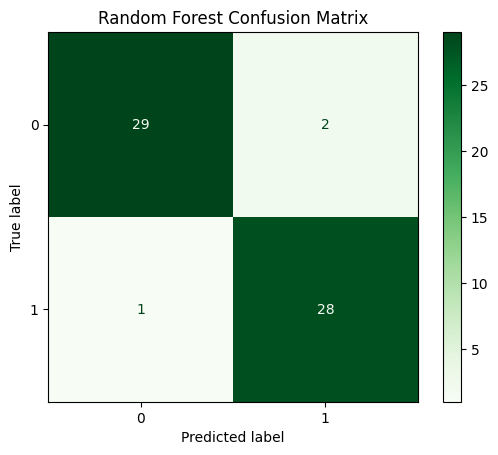

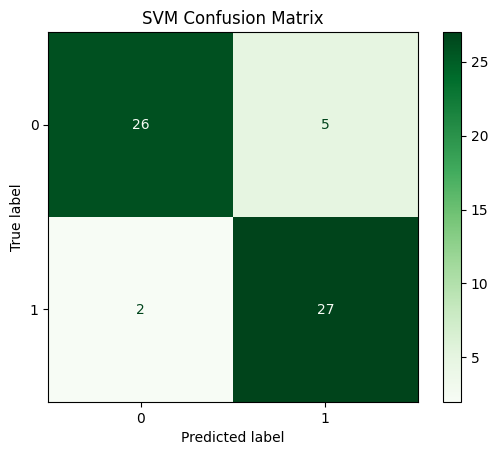

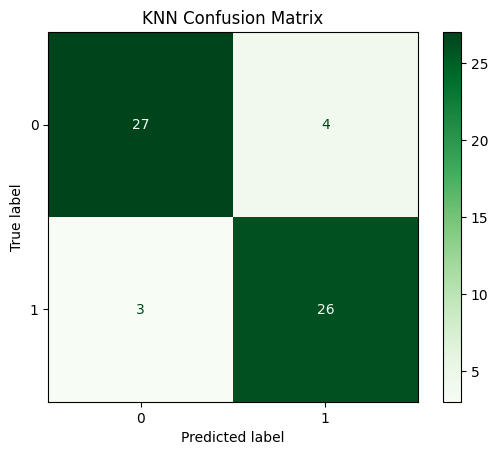

In [33]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Greens)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(x_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(x_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(x_test), "KNN Confusion Matrix")